# Датасет: Amazon Delivery Dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
import numpy as np
import warnings
warnings.filterwarnings("ignore")

В качестве датасета для анализа будет использован датасет с данными о доставках Amazon Delivery https://www.kaggle.com/datasets/sujalsuthar/amazon-delivery-dataset.

Этот набор данных о доставках Amazon дает полное представление о логистических операциях компании на этапе "последней мили". Он включает данные о более чем 43 632 доставках из разных городов с подробной информацией о деталях заказа, агентах по доставке, погодных условиях и дорожном движении, а также о показателях эффективности доставки. Этот набор данных позволяет исследователям и аналитикам получить представление о факторах, влияющих на эффективность доставки, определить области для оптимизации и изучить влияние различных переменных на общее качество обслуживания клиентов.

# Загрузка и изучение данных

In [3]:
amazon_delivery = pd.read_csv('amazon_delivery.csv')

In [4]:
amazon_delivery.head()

Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude  Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471  2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237  2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400  2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494  2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982  2022-03-26   13:30:00    13:45:00   

      Weather  Traffic      Vehicle            Area  Delivery_Time  \
0       Sunny    High   motorcycle           Urban             120   
1      Stormy     Jam      scooter   Metropolitian             165   
2  Sandstorms     Low   motorcycle           Urban             130   
3       Sunny  Medium   motorcycle   Metropolitian             105   
4      Cloudy    High      scooter   Metropolitian             150   

      Category  
0     Clothing  
1  Electronics  
2       Sports  
3    Cosmetics  
4         Toys

## Сбор простых статистик с помощью ProfileReport

In [5]:
from ydata_profiling import ProfileReport
import pandas as pd

# Ваш код

In [6]:
profile = ProfileReport(amazon_delivery, title="Pandas Profiling Report")

In [7]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 17.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Глядя на матрицу корреляций, можно сделать первичные выводы о скоррелированности возраста и трафика и рейтинга и трафика 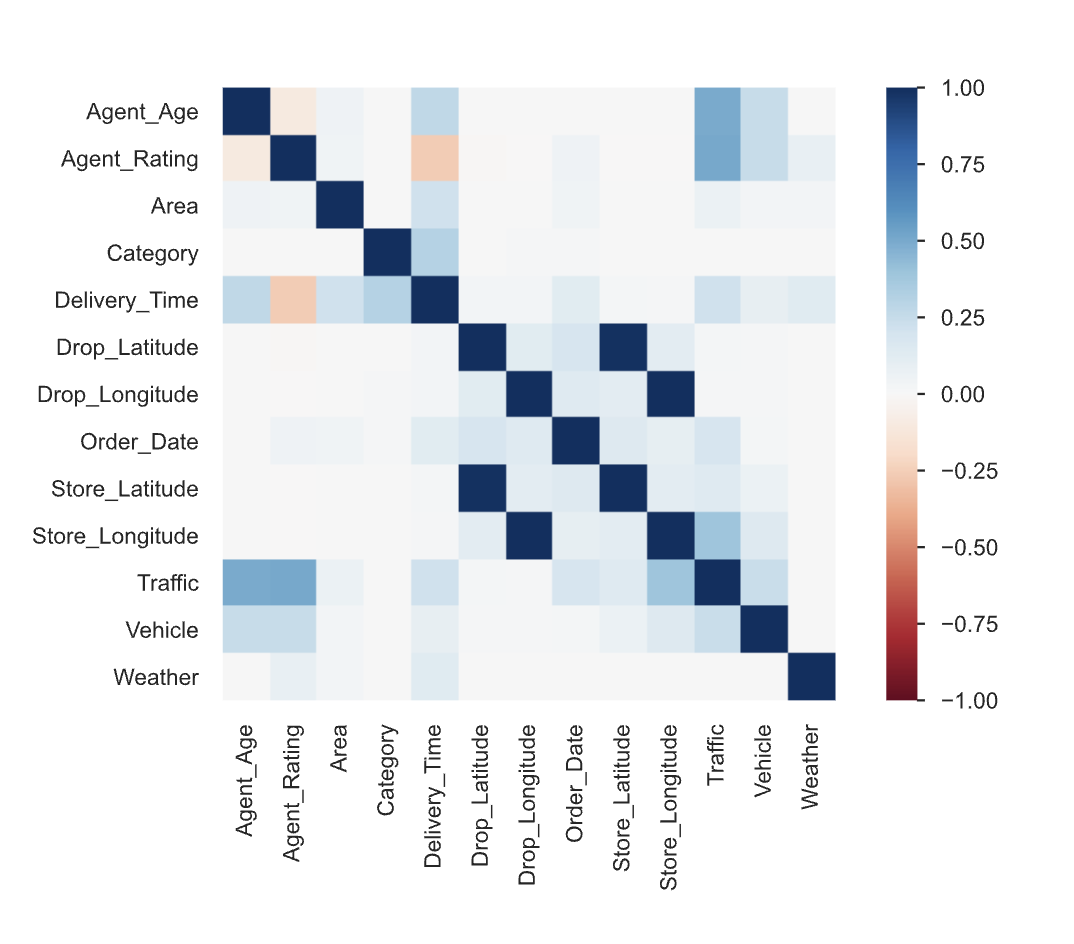

Другие выводы:
- самый популярный тип транспорта motorcycle;
- самая популярный район доставки Metropolitian

In [6]:
amazon_delivery.head()

Order_ID  Agent_Age  Agent_Rating  Store_Latitude  Store_Longitude  \
0  ialx566343618         37           4.9       22.745049        75.892471   
1  akqg208421122         34           4.5       12.913041        77.683237   
2  njpu434582536         23           4.4       12.914264        77.678400   
3  rjto796129700         38           4.7       11.003669        76.976494   
4  zguw716275638         32           4.6       12.972793        80.249982   

   Drop_Latitude  Drop_Longitude  Order_Date Order_Time Pickup_Time  \
0      22.765049       75.912471  2022-03-19   11:30:00    11:45:00   
1      13.043041       77.813237  2022-03-25   19:45:00    19:50:00   
2      12.924264       77.688400  2022-03-19   08:30:00    08:45:00   
3      11.053669       77.026494  2022-04-05   18:00:00    18:10:00   
4      13.012793       80.289982  2022-03-26   13:30:00    13:45:00   

      Weather  Traffic      Vehicle            Area  Delivery_Time  \
0       Sunny    High   motorcycle           Urban             120   
1      Stormy     Jam      scooter   Metropolitian             165   
2  Sandstorms     Low   motorcycle           Urban             130   
3       Sunny  Medium   motorcycle   Metropolitian             105   
4      Cloudy    High      scooter   Metropolitian             150   

      Category  
0     Clothing  
1  Electronics  
2       Sports  
3    Cosmetics  
4         Toys

In [8]:
amazon_delivery.Order_ID.nunique(), amazon_delivery.Order_ID.count()

(43739, 43739)

Заказы являются уникальными

## Визуализация плотности заказов по регионам с помощью GeoPandas

В данной части проекта представлена карта из H3-полигонов, на которой отображены регионы доставки и цветом обозначено количество заказов в этих регионах

In [7]:
df = amazon_delivery.copy()

In [8]:
df_ = df.copy()

In [9]:
df_ = df_[df_.Store_Latitude!=0]

In [10]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import osmnx as ox
from shapely import wkt
from folium.plugins import HeatMap
from shapely.geometry import Polygon

In [32]:
import branca.colormap as cm  # Для создания цветовой шкалы

def visualize_hexagons(hexagon_data, colormap, folium_map=None):
    """
    Визуализирует H3 гексагоны на карте Folium, раскрашивая их в зависимости от данных.

    Args:
        hexagon_data (dict): Словарь, где ключи - H3 индексы, а значения - данные (например, количество заказов).
        colormap (branca.colormap.ColorMap): Цветовая шкала для раскраски гексагонов.
        folium_map (folium.Map, optional): Существующая карта Folium. Создается новая, если None. Defaults to None.

    Returns:
        folium.Map: Карта Folium с визуализированными гексагонами.
    """
    polylines = []
    lat = []
    lng = []

    for hex_index, data_value in hexagon_data.items():
        polygons = h3.h3_set_to_multi_polygon([hex_index], geo_json=False)
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]  
        polylines.append(polyline)
        lat.extend(map(lambda v: v[0], polyline))
        lng.extend(map(lambda v: v[1], polyline))


    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=12, tiles='cartodbpositron') 
    else:
        m = folium_map

    for i, polyline in enumerate(polylines):
        hex_index = list(hexagon_data.keys())[i] 
        data_value = hexagon_data[hex_index]
        color = colormap(data_value) 

        folium.Polygon(
            locations=polyline,
            color=None, 
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=f"H3 Index: {hex_index}<br>Value: {data_value}"
        ).add_to(m)


    return m

In [33]:
RESOLUTION = 6
df_['h3_index'] = df_.apply(lambda row: h3.geo_to_h3(row['Drop_Latitude'], row['Drop_Longitude'], RESOLUTION), axis=1)

hexagon_counts = df_.groupby('h3_index')['Order_ID'].count().reset_index()
hexagon_counts.rename(columns={'Order_ID': 'order_count'}, inplace=True)
hexagon_data = dict(zip(hexagon_counts['h3_index'], hexagon_counts['order_count']))

min_orders = hexagon_counts['order_count'].min()
max_orders = hexagon_counts['order_count'].max()

colormap = cm.LinearColormap(
    colors=['red', 'yellow', 'green'],
    vmin=min_orders,
    vmax=max_orders,
    caption="Number of Orders"
)

mean_lat = df_['Drop_Latitude'].mean()
mean_lon = df_['Drop_Longitude'].mean()

m = folium.Map(location=[mean_lat, mean_lon], zoom_start=5, tiles='cartodbpositron')
m = visualize_hexagons(hexagon_data, colormap, folium_map=m) 

m.add_child(colormap)

In [34]:
m.save("h3_map_colored_polygon.html")

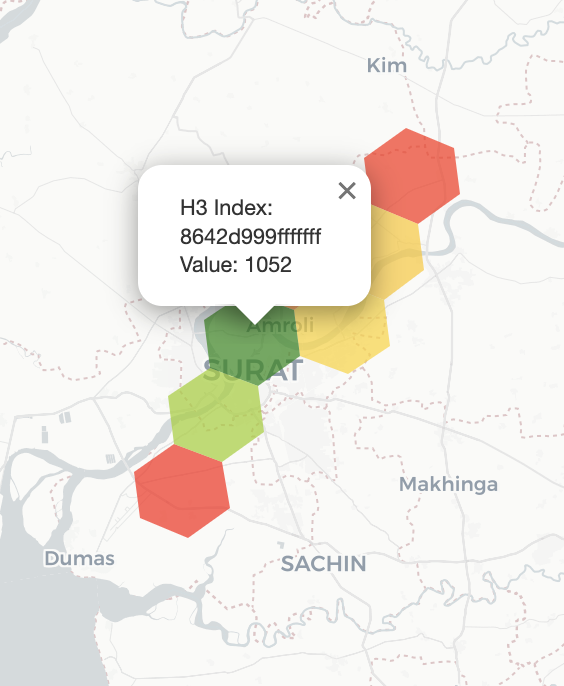

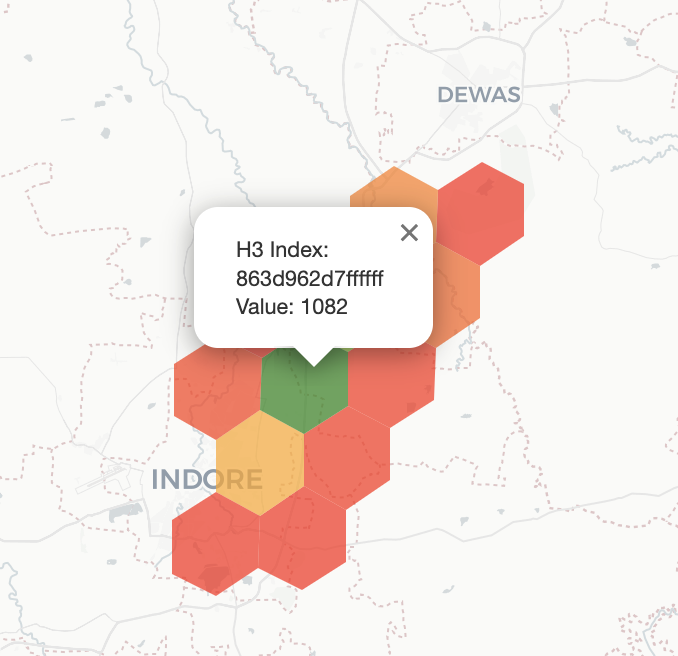

# Исследования

## Скорости доставки

In [16]:
import pandas as pd
from geopy.distance import geodesic

def calculate_distance(row):
    start = (df['Store_Latitude'].iloc[0], df['Store_Longitude'].iloc[0]) 
    end = (row['Drop_Latitude'], row['Drop_Longitude']) 
    return geodesic(start, end).km 

df_['distance'] = df_.apply(calculate_distance, axis=1)

In [17]:
df_['speed'] = df_['distance'] / df_['Delivery_Time']

In [38]:
def visualize(data, x, y, t='Speed в зависимости от Area'):
    f = plt.figure(figsize=(10, 4))
    sns.boxplot(data=data, x=x, y=y)
    plt.title(t)
    plt.xticks(rotation=90)
    plt.show()

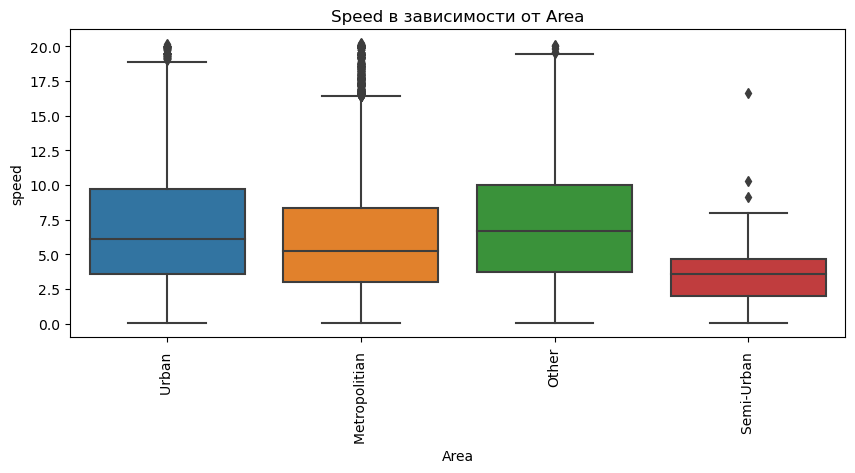

In [39]:
visualize(data=df_[df_.speed<df_.speed.quantile(0.95)],
          x='Area', y='speed', t='Speed в зависимости от Area')

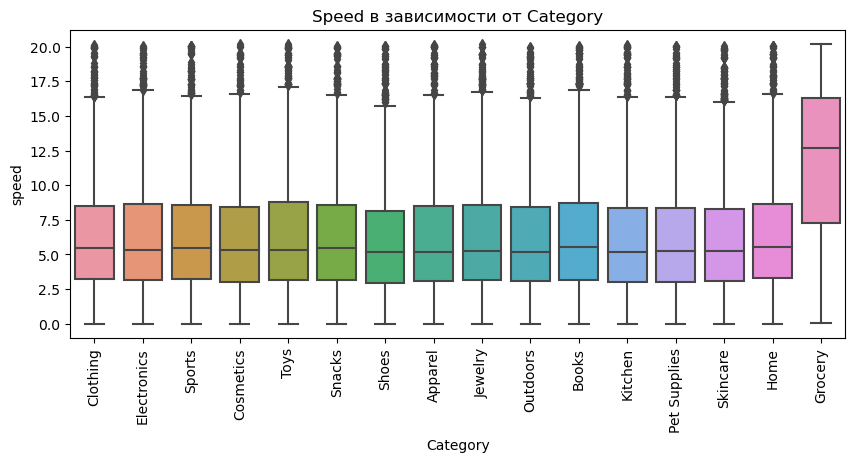

In [40]:
visualize(data=df_[df_.speed<df_.speed.quantile(0.95)],
          x='Category', y='speed', t='Speed в зависимости от Category')

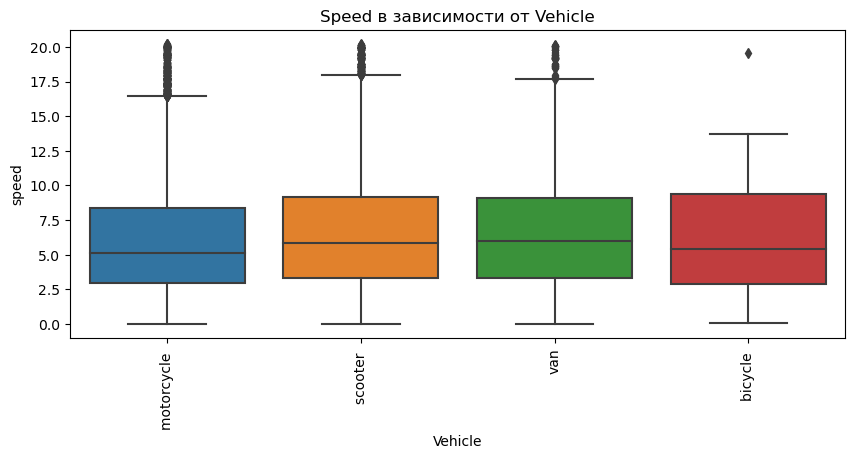

In [42]:
visualize(data=df_[df_.speed<df_.speed.quantile(0.95)],
          x='Vehicle', y='speed', t='Speed в зависимости от Vehicle')

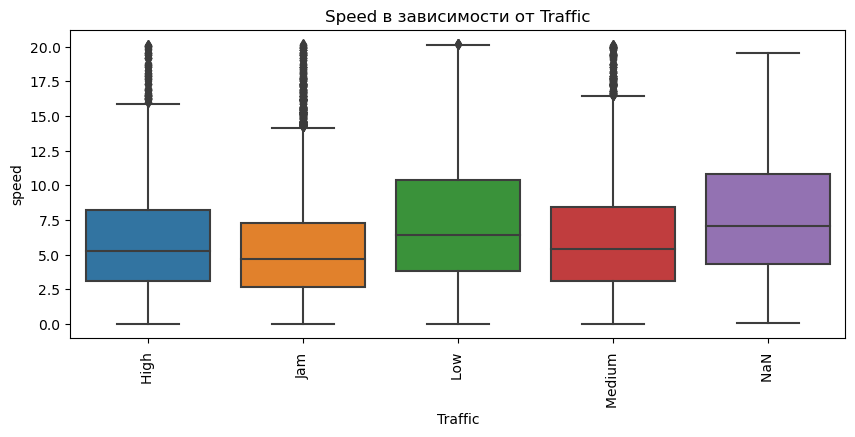

In [44]:
visualize(data=df_[df_.speed<df_.speed.quantile(0.95)],
          x='Traffic', y='speed', t='Speed в зависимости от Traffic')

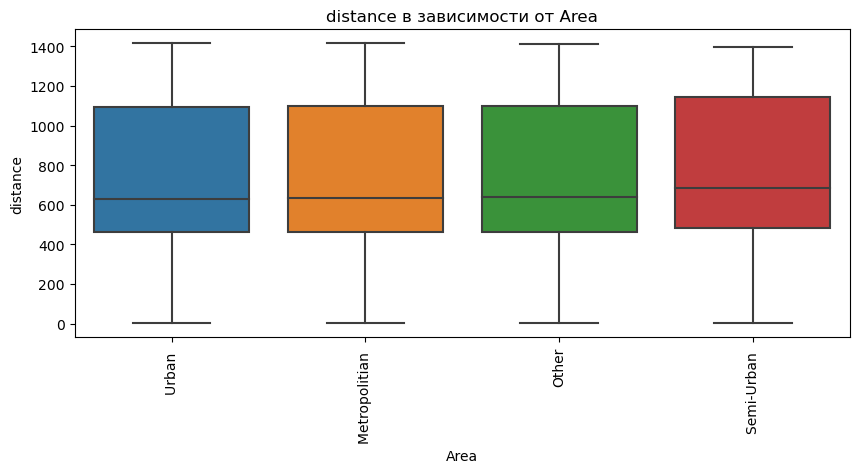

In [51]:
visualize(data=df_[df_.speed<df_.speed.quantile(0.95)],
          x='Area', y='distance', t='distance в зависимости от Area')

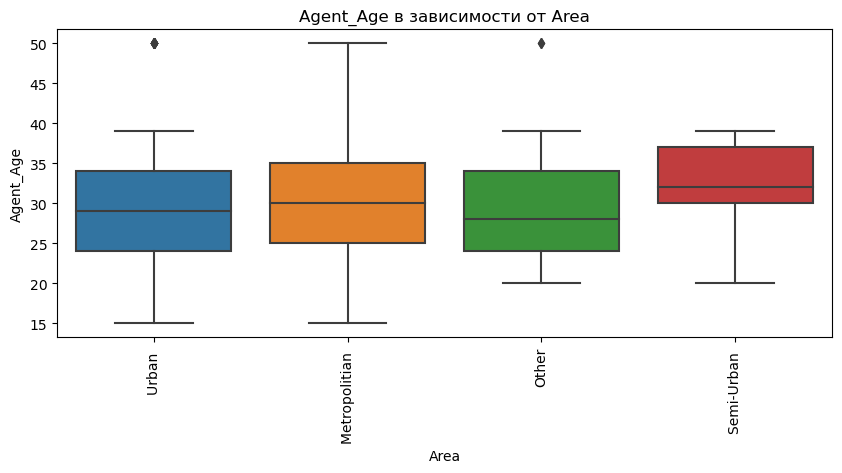

In [53]:
visualize(data=df_[df_.speed<df_.speed.quantile(0.95)],
          x='Area', y='Agent_Age', t='Agent_Age в зависимости от Area')

Видно, что для grocery заказов скорость доставки является самой высокой, при этом также видно, что для низкого трафика сокрость больше.
Что касается Area Semi-Urban, здесь была гипотеза: в данной локации возраст курьеров в среднем выше, так как видно было, что в Semi-Urban самая низкая скорость. Эта гипотеза подтвердилась.

## Время доставки

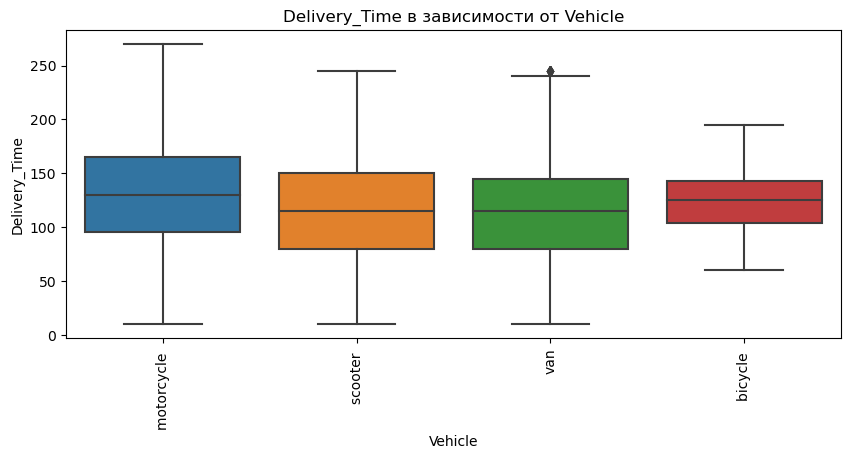

In [54]:
visualize(data=df_,
          x='Vehicle', y='Delivery_Time', t='Delivery_Time в зависимости от Vehicle')

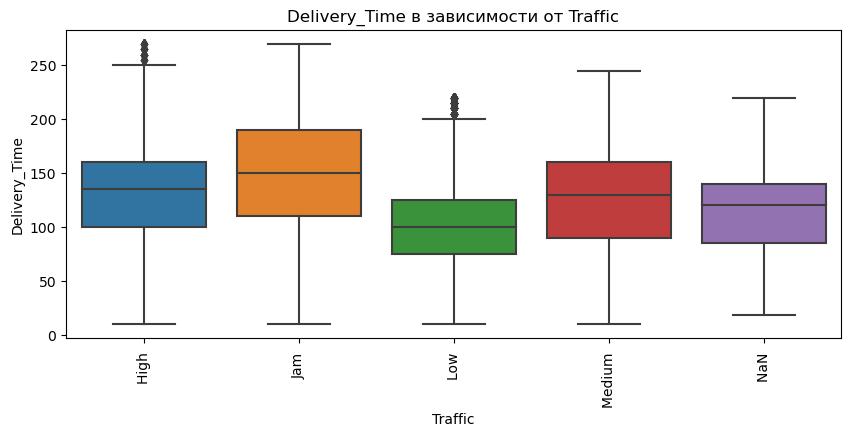

In [55]:
visualize(data=df_,
          x='Traffic', y='Delivery_Time', t='Delivery_Time в зависимости от Traffic')

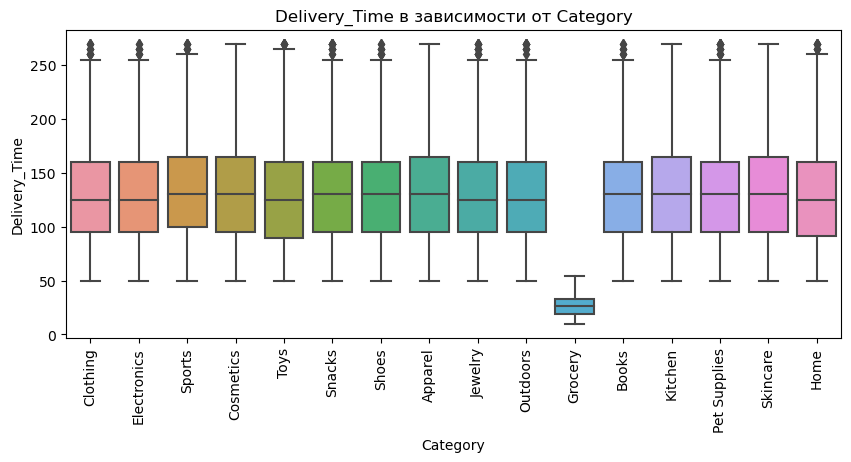

In [56]:
visualize(data=df_,
          x='Category', y='Delivery_Time', t='Delivery_Time в зависимости от Category')

## Зависимость производительности от возраста у курьеров

В прошлых частях исследования мы заметили, что скорость курьеров зависит от региона, но также мы увидели, что в самом плохом регионе самый высокий возраст курьеров. Здесь исследуем возраст курьеров внимательнее

In [62]:
df['Order_Time'] = pd.to_datetime("2023-01-01 " + df['Order_Time'], errors='coerce')
df['Pickup_Time'] = pd.to_datetime("2023-01-01 " + df['Pickup_Time'], errors='coerce')
df['Lead_Time_Minutes'] = (df['Pickup_Time'] - df['Order_Time']).dt.total_seconds() / 60
df['Lead_Time_Minutes'] = df['Lead_Time_Minutes'].apply(lambda x: x if pd.notnull(x) and x >= 0 else (x + 24*60 if pd.notnull(x) else None))

Избавимся от заказов, которые ни на кого не назначились

In [82]:
df = df.dropna(subset=['Lead_Time_Minutes'])

In [76]:
result = df.groupby('Agent_Age', as_index=False)['Delivery_Time'].mean()

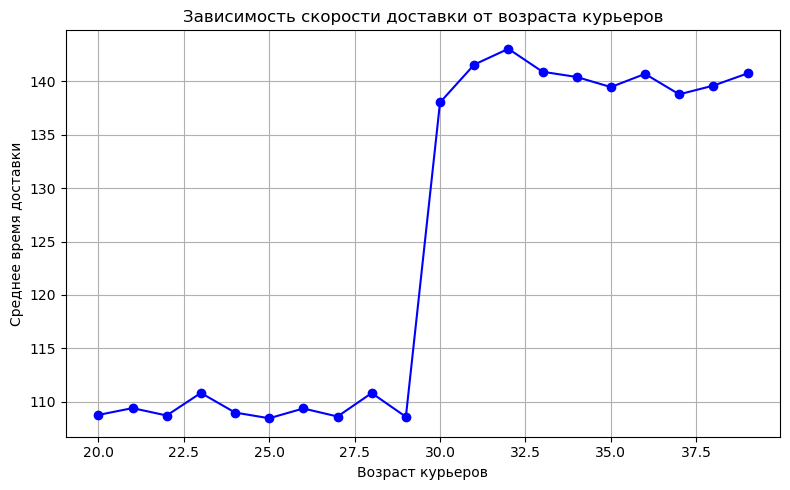

In [79]:
plt.figure(figsize=(8, 5))
plt.plot(result['Agent_Age'], result['Delivery_Time'], marker='o', linestyle='-', color='b')

plt.title('Зависимость скорости доставки от возраста курьеров')
plt.xlabel('Возраст курьеров')
plt.ylabel('Среднее время доставки')
plt.grid(True)
plt.tight_layout()

plt.show()

In [80]:
result = df.groupby('Agent_Age', as_index=False)['Agent_Rating'].mean()

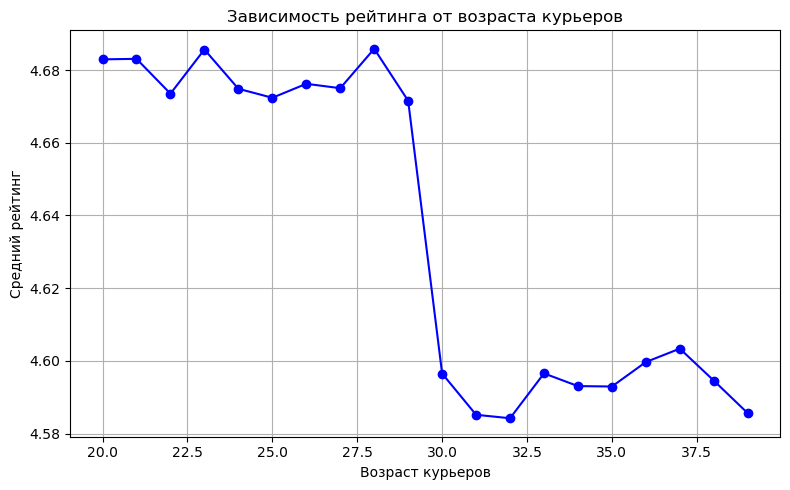

In [81]:
plt.figure(figsize=(8, 5))
plt.plot(result['Agent_Age'], result['Agent_Rating'], marker='o', linestyle='-', color='b')

plt.title('Зависимость рейтинга от возраста курьеров')
plt.xlabel('Возраст курьеров')
plt.ylabel('Средний рейтинг')
plt.grid(True)
plt.tight_layout()

plt.show()

Как видно, от возраста курьеров действительно зависит их производительность

# Предсказательная модель

In [99]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

df = amazon_delivery.copy()
features = ['Agent_Age', 'Agent_Rating', 'Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
target = 'Delivery_Time'

for col in ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = df[features]
y = df[target]
categorical_features_indices = [X.columns.get_loc(col) for col in ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']] # Индексы категориальных признаков


kf = KFold(n_splits=5, shuffle=True, random_state=42)  
oof_predictions = np.zeros(len(df))  
models = [] 
rmse_scores = [] 

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
    val_pool = Pool(X_val, y_val, cat_features=categorical_features_indices)

    model = CatBoostRegressor(
        iterations=1000, 
        learning_rate=0.2, 
        depth=5,           
        l2_leaf_reg=3,      
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        verbose=False
    )


    model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=10) # Early stopping

    oof_predictions[val_index] = model.predict(X_val)
    models.append(model)
    rmse = np.sqrt(mean_squared_error(y_val, oof_predictions[val_index]))
    rmse_scores.append(rmse)

    print(f"Fold {fold+1} RMSE: {rmse}")


overall_rmse = np.sqrt(mean_squared_error(y, oof_predictions))
print(f"Overall RMSE: {overall_rmse}")
print(f"Mean RMSE across folds: {np.mean(rmse_scores)}")

feature_importance = models[-1].get_feature_importance() 
feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance_df)

Fold 1
Fold 1 RMSE: 27.494339148108832
Fold 2
Fold 2 RMSE: 27.9792434638214
Fold 3
Fold 3 RMSE: 27.690148663585852
Fold 4
Fold 4 RMSE: 27.68021332244035
Fold 5
Fold 5 RMSE: 27.95998100755545
Overall RMSE: 27.761392492442482
Mean RMSE across folds: 27.76078512110238

Feature Importance:
        Feature  Importance
6      Category   33.124532
3       Traffic   21.405928
1  Agent_Rating   15.772498
2       Weather   12.329696
0     Agent_Age   11.624135
4       Vehicle    3.553148
5          Area    2.190064


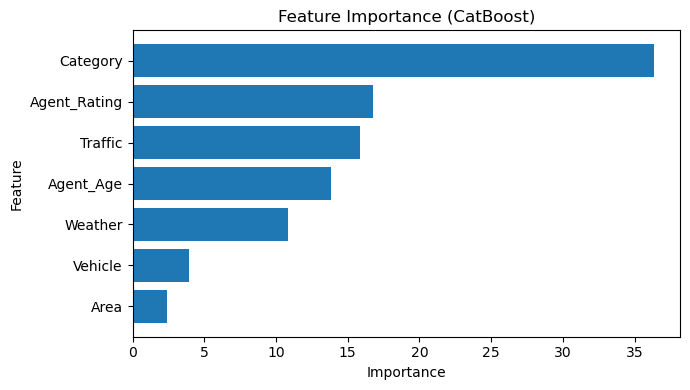

In [98]:
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=True) 

plt.figure(figsize=(7, 4))

plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance']) 
plt.xlabel('Importance') 
plt.ylabel('Feature') 
plt.title('Feature Importance (CatBoost)') 
plt.tight_layout() 
plt.show() 

In [100]:
df.Delivery_Time.mean()

124.90564484784746

## Выводы о влиянии признаков на время доставки:

Наибольшее влияние оказывают:

1. Категория товара (33.12%): Тип товара – ключевой фактор, определяющий требования к доставке.
2. Интенсивность трафика (21.41%): Загруженность дорог существенно увеличивает время доставки.
3. Рейтинг агента (15.77%): Опыт и навыки курьера влияют на скорость доставки.
4. Погодные условия (12.33%): Плохая погода замедляет движение.
5. Возраст агента (11.62%): Может быть связан с опытом и выносливостью.
6. Транспортное средство (3.55%): Менее значимый фактор.
7. Район доставки (2.19%): Наименьшее влияние.

Оценка качества модели:

Модель имеет RMSE 27.76 минут, что соответствует относительной ошибке в 22.22% при среднем времени доставки 124.91 минут. Такая погрешность может быть значительной для пользователей.

Рекомендации по улучшению модели:

-  Добавить больше признаков (о заказе, курьере, маршруте).
-  Улучшить обработку признаков и их комбинации.
-  Тщательно подобрать гиперпараметры модели.
-  Использовать более сложные модели или ансамбли.
-  Анализировать ошибки и учитывать сезонность/время суток.

Модель полезна для понимания ключевых факторов, но требует улучшения для повышения точности прогнозирования и практического использования.